# 2.5 自动微分

## 实验代码运行

In [1]:
from mxnet import autograd, np, npx

npx.set_np()

x = np.arange(4.0)
x

array([0., 1., 2., 3.])

In [2]:
# 通过调用attach_grad来为一个张量的梯度分配内存
x.attach_grad()
# 在计算关于x的梯度后，将能够通过'grad'属性访问它，它的值被初始化为0
x.grad

array([0., 0., 0., 0.])

对函数 $y = 2 \bm{x}^T\bm{x}$ ，对列向量 $\bm{x}$ 求导。

In [3]:
# 把代码放到autograd.record内，以建立计算图
with autograd.record():
    y = 2 * np.dot(x, x)
y

array(28.)

In [4]:
y.backward()
x.grad

array([ 0.,  4.,  8., 12.])

函数 $y = 2 \bm{x}^T \bm{x}$ 关于 $\bm{x}$ 的梯度应为 $4\bm{x}$，验证是否正确：

In [5]:
x.grad == 4 * x

array([ True,  True,  True,  True])

In [6]:
with autograd.record():
    y = x.sum()
y.backward()
x.grad  # 被新计算的梯度覆盖

array([1., 1., 1., 1.])

非标量变量的方向传播：

In [ ]:
# 当对向量值变量y（关于x的函数）调用backward时，将通过对y中的元素求和来创建
# 一个新的标量变量。然后计算这个标量变量相对于x的梯度
with autograd.record():
    y = x * x  # y是一个向量
y.backward()
x.grad  # 等价于y=sum(x*x)

In [7]:
with autograd.record():
    y = x * x
    u = y.detach()
    z = u * x
z.backward()
x.grad == u

array([ True,  True,  True,  True])

In [8]:
y.backward()
x.grad == 2 * x

array([ True,  True,  True,  True])

In [9]:
def f(a):
    b = a * 2
    while np.linalg.norm(b) < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [10]:
a = np.random.normal()
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

In [11]:
a.grad == d / a

array(True)

## 练习题

练习题 1：为什么计算二阶导数比计算一阶导数的开销要更大？

因为计算二阶导数需要计算一阶导数，开销就会更大。

练习题 2：在运行反向传播函数之后，立即再次运行它，看看会发生什么

Cannot differentiate node because it is not in a computational graph. 

前向过程建立的计算图，会在反向传播后释放，所以第二次运行反向传播就会出错。

In [17]:
with autograd.record():
    y = x * x  # y是一个向量
y.backward()
x.grad  # 等价于y=sum(x*x)
y.backward()

MXNetError: Traceback (most recent call last):
  File "../src/imperative/imperative.cc", line 295
MXNetError: Check failed: !AGInfo: :IsNone(*i): Cannot differentiate node because it is not in a computational graph. You need to set is_recording to true or use autograd.record() to save computational graphs for backward. If you want to differentiate the same graph twice, you need to pass retain_graph=True to backward.

练习题 3：在控制流的例子中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发生什么？

发生错误。张量无法对张量求导，只能是标量对张量求导，因此如果我们将 a 修改为向量或矩阵，直接 backward 将会报错，需要对结果求和成一个标量后方能求导

练习题 4：重新设计一个求控制流梯度的例子，运行并分析结果

In [29]:
def f(a):
    if a.sum() > 0:
        c = a
    else:
        c = 10 * a
    return c

a = np.random.normal()
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

a.grad == d / a

array(True)

练习题 5：使 $f(x) = sin(x)$，绘制 $f(x)$ 和 $\frac{df(x)}{dx}$ 的图像，其中后者不使用 $f^\prime (x) = cos(x)$

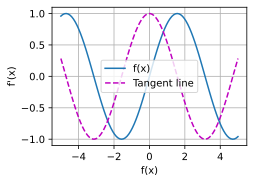

In [36]:
from d2l import mxnet as d2l
x = np.linspace(-5, 5, 100)

x.attach_grad()
with autograd.record():
    y = np.sin(x)

y.backward()

d2l.plot(x.detach(), [y, x.grad], 'f(x)', "f'(x)", legend=['f(x)', 'Tangent line'])